In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style

In [2]:
start = '2022-07-01'
end = '2023-02-17'
interval = "1d"

# Applying MPL to find assets

In [3]:
tickers = ["AAPL","TSLA","BTC-USD", "NFLX","ETH-USD", "AMZN", "NVDA", "SPY"]
df = yf.download(tickers, start = start, end = end, interval = interval)
df = df.interpolate().dropna()
close = df.loc[:,"Close"].copy()

[*********************100%***********************]  8 of 8 completed


In [4]:
ret = close.pct_change().dropna()
ret

,AAPL,AMZN,BTC-USD,ETH-USD,NFLX,NVDA,SPY,TSLA
Date,,,,,,,,
2022-07-02,0.004733,0.008991,-0.001407,0.006365,0.008238,0.007591,0.000472,0.006384
2022-07-03,0.004710,0.008910,0.002849,0.006802,0.008171,0.007534,0.000472,0.006343
2022-07-04,0.004688,0.008832,0.048411,0.071982,0.008105,0.007478,0.000472,0.006303
2022-07-05,0.004666,0.008754,-0.002034,-0.014350,0.008040,0.007422,0.000471,0.006264
2022-07-06,0.009607,0.007313,0.017738,0.046215,-0.009791,0.011093,0.003377,-0.005721
...,...,...,...,...,...,...,...,...
2023-02-12,0.006230,0.006548,-0.003780,-0.016165,0.010643,0.008131,0.003898,-0.003824
2023-02-13,0.006191,0.006505,0.000913,-0.005193,0.010531,0.008066,0.003883,-0.003838
2023-02-14,-0.004225,0.001607,0.018924,0.032982,0.003876,0.054296,-0.000460,0.075062


In [5]:
summ = ret.describe().T.loc[:,["mean","std"]]
summ["mean"] = summ["mean"]*len(ret)
summ["std"] = summ["std"]*np.sqrt(len(ret))
summ["returns/risk ratio"] = summ["mean"]/summ["std"]
summ.sort_values(by = ["returns/risk ratio"], ascending=False)

,mean,std,returns/risk ratio
NFLX,0.747629,0.403075,1.854812
NVDA,0.508576,0.432896,1.174822
ETH-USD,0.660804,0.638934,1.034229
BTC-USD,0.326969,0.434455,0.752596
AAPL,0.133183,0.254689,0.522923
SPY,0.082367,0.166961,0.493334
TSLA,-0.012125,0.461971,-0.026246
AMZN,-0.047812,0.354857,-0.134736


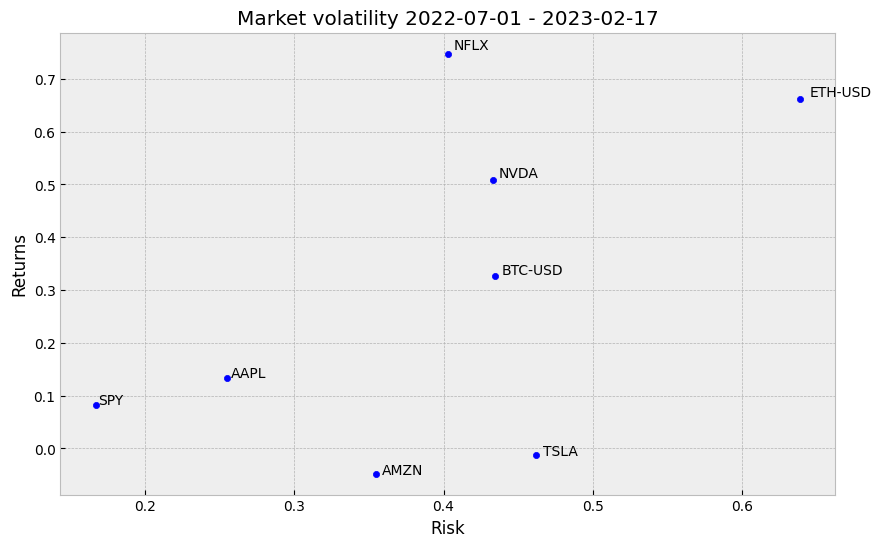

In [6]:
style.use('bmh')
summ.plot.scatter(x = "std", y = "mean", figsize = (10,6))
plt.xlabel("Risk")
plt.ylabel("Returns")
plt.title(f'Market volatility {start} - {end}')

for i in summ.index:
    plt.annotate(i, xy = (summ.loc[i,"std"]+0.01*summ.loc[i,"std"], summ.loc[i,"mean"]+0.01*summ.loc[i,"mean"])) 

In [7]:
colors = sns.color_palette("hls", 10)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Text(0.5, 0.98, 'Stock price trends 2022-07-01 - 2023-02-17')

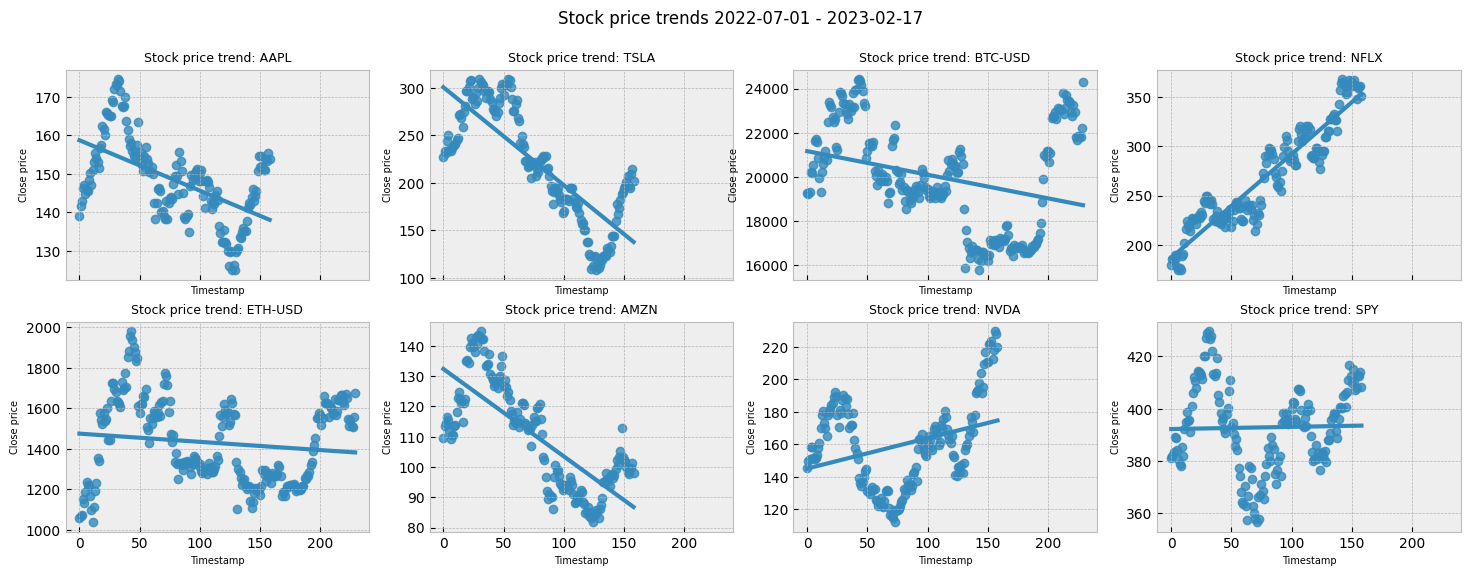

In [8]:
fig, axs = plt.subplots(2,4,figsize=(18,6), sharex = True)  

for ticker in tickers:
    if tickers.index(ticker) <= 3:
        i = 0
        m = 0
    else:
        i = 1
        m = 4
    df = yf.download(ticker, start = start, end = end, interval = interval)
    data = df.Close.to_frame().reset_index()
    sns.regplot(data = data, x=data.index, 
                y=data.Close, ci = None, 
                fit_reg = True, ax = axs[i,tickers.index(ticker)-m])
    axs[i,tickers.index(ticker)-m].set_title(f'Stock price trend: {ticker}', fontsize = 9)
    axs[i,tickers.index(ticker)-m].set_xlabel("Timestamp", fontsize = 7)
    axs[i,tickers.index(ticker)-m].set_ylabel("Close price", fontsize = 7)

#for ax in axs.flat:
#    ax.label_outer()

plt.suptitle(f'Stock price trends {start} - {end}')

## SMA strategy

In [9]:
def test_strategy(stock, start, end, interval, SMA, short):
    df = yf.download(stock, start=start, end=end, interval = interval)
    data = df.Close.to_frame()
    data["returns"] = np.log(data.Close.div(data.Close.shift(1)))
    data["SMA_S"] = data.Close.rolling(int(SMA[0])).mean()
    data["SMA_L"] = data.Close.rolling(int(SMA[1])).mean()
    data.dropna(inplace=True)
    
    data["position"] = np.where(data["SMA_S"]>data["SMA_L"],1,int(short))
    data["strategy"] = data["returns"]*data.position.shift(1)
    data.dropna(inplace=True)
    ret = np.exp(data["strategy"].sum())
    std = data["strategy"].std()*np.sqrt(len(data))
    
    return data, ret, std

In [10]:
#long-short
for ticker in tickers:
    print(f'{ticker}: {test_strategy(ticker, start = start, end = end, interval = interval, SMA = (20,100), short = -1)[1:]}')

[*********************100%***********************]  1 of 1 completed
AAPL: (0.985742067872312, 0.14556610184613697)
[*********************100%***********************]  1 of 1 completed
TSLA: (0.8308750776854701, 0.3892928583389926)
[*********************100%***********************]  1 of 1 completed
BTC-USD: (1.0539625465352453, 0.3177171009430812)
[*********************100%***********************]  1 of 1 completed
NFLX: (1.2303455761232946, 0.21589185420685775)
[*********************100%***********************]  1 of 1 completed
ETH-USD: (0.8855414302038367, 0.44104294078253925)
[*********************100%***********************]  1 of 1 completed
AMZN: (0.952479340526372, 0.2018265032533409)
[*********************100%***********************]  1 of 1 completed
NVDA: (1.2730949234351971, 0.28055386980160774)
[*********************100%***********************]  1 of 1 completed
SPY: (0.9171989904041297, 0.08808753484504558)


In [11]:
#long biased
for ticker in tickers:
    print(f'{ticker}: {test_strategy(ticker, start = start, end = end, interval = interval, SMA = (20,100), short = 0)[1:]}')

[*********************100%***********************]  1 of 1 completed
AAPL: (1.0117825735024777, 0.026917797872907375)
[*********************100%***********************]  1 of 1 completed
TSLA: (1.0, 0.0)
[*********************100%***********************]  1 of 1 completed
BTC-USD: (1.1486813015000512, 0.15030143402897897)
[*********************100%***********************]  1 of 1 completed
NFLX: (1.2303455761232946, 0.21589185420685775)
[*********************100%***********************]  1 of 1 completed
ETH-USD: (1.0614601832254427, 0.17251866076000655)
[*********************100%***********************]  1 of 1 completed
AMZN: (1.0055322294042692, 0.03918198790303814)
[*********************100%***********************]  1 of 1 completed
NVDA: (1.3523049071872653, 0.27362366668734545)
[*********************100%***********************]  1 of 1 completed
SPY: (0.9741768411841664, 0.0720567959668505)


In [12]:
#sma 9,25
for ticker in tickers:
    print(f'{ticker}: {test_strategy(ticker, start = start, end = end, interval = interval, SMA = (9,25), short = 0)[1:]}')

[*********************100%***********************]  1 of 1 completed
AAPL: (0.9898197717654013, 0.18495350887740444)
[*********************100%***********************]  1 of 1 completed
TSLA: (1.1975331612543738, 0.25555791894505253)
[*********************100%***********************]  1 of 1 completed
BTC-USD: (0.9529845959801913, 0.3288777609299259)
[*********************100%***********************]  1 of 1 completed
NFLX: (1.0573185314513083, 0.3194711403412713)
[*********************100%***********************]  1 of 1 completed
ETH-USD: (0.8865186396706543, 0.5032690754932908)
[*********************100%***********************]  1 of 1 completed
AMZN: (0.841122179379128, 0.18950553503686393)
[*********************100%***********************]  1 of 1 completed
NVDA: (1.2800752693968267, 0.34399572870665396)
[*********************100%***********************]  1 of 1 completed
SPY: (0.9988029768076047, 0.11841617491342166)


## WVAP strategy

In [13]:
def test_strategy2(stock, start, end, interval, short):
    df = yf.download(stock, start=start, end=end, interval = interval)
    data = df[["Close","Volume"]].copy()
    data["VWAP"] = (data.Volume.values * data.Close.values).cumsum() / data.Volume.values.cumsum()
    data["returns"] = np.log(data.Close.div(data.Close.shift(1)))
    data.dropna(inplace=True)
    
    data["position"] = np.where(data["VWAP"]<data["Close"],1, int(short))
    data["strategy"] = data["returns"]*data.position.shift(1)
    data.dropna(inplace=True)
    ret = np.exp(data["strategy"].sum())
    std = data["strategy"].std()*np.sqrt(len(data))
    
    return data, ret, std

In [14]:
for ticker in tickers:
    print(f'{ticker}: {test_strategy2(ticker, start = start, end = end, interval = interval, short = -1)[1:]}')

[*********************100%***********************]  1 of 1 completed
AAPL: (0.9783001843560026, 0.2684388593475874)
[*********************100%***********************]  1 of 1 completed
TSLA: (1.2227301908258983, 0.5229009686732823)
[*********************100%***********************]  1 of 1 completed
BTC-USD: (0.9322291845196354, 0.4369269182791587)
[*********************100%***********************]  1 of 1 completed
NFLX: (1.4093549737684559, 0.4179762006340604)
[*********************100%***********************]  1 of 1 completed
ETH-USD: (0.7867077798476564, 0.6399839163566529)
[*********************100%***********************]  1 of 1 completed
AMZN: (0.9509558315562311, 0.36637709360871784)
[*********************100%***********************]  1 of 1 completed
NVDA: (1.2160849098806692, 0.4630103221882884)
[*********************100%***********************]  1 of 1 completed
SPY: (0.910808764065696, 0.17476829303695215)


In [15]:
for ticker in tickers:
    print(f'{ticker}: {test_strategy2(ticker, start = start, end = end, interval = interval, short = 0)[1:]}')

[*********************100%***********************]  1 of 1 completed
AAPL: (1.0306634265119698, 0.13367822775216787)
[*********************100%***********************]  1 of 1 completed
TSLA: (1.0295416224377603, 0.2556458375744073)
[*********************100%***********************]  1 of 1 completed
BTC-USD: (1.0851919300543158, 0.2747643373440073)
[*********************100%***********************]  1 of 1 completed
NFLX: (1.6306769336079667, 0.4044514332929386)
[*********************100%***********************]  1 of 1 completed
ETH-USD: (1.111139163927434, 0.4879987843112135)
[*********************100%***********************]  1 of 1 completed
AMZN: (0.9068331705887616, 0.20789089642885392)
[*********************100%***********************]  1 of 1 completed
NVDA: (1.3371778845742104, 0.35137931465272015)
[*********************100%***********************]  1 of 1 completed
SPY: (0.9866967900806993, 0.11682127617271211)


## MACD strategy

In [16]:
def test_strategy3(stock, start, end, interval, short):
    df = yf.download(stock, start=start, end=end, interval = interval)
    data = df.Close.to_frame()
    data["returns"] = np.log(data.Close.div(data.Close.shift(1)))
    
    d = data.Close.ewm(span=12, adjust=False, min_periods=12).mean()
    k = data.Close.ewm(span=26, adjust=False, min_periods=26).mean()
    data["macd"] = k - d
    data["macd_s"] = data.macd.ewm(span=9, adjust=False, min_periods=9).mean()
    data["macd_h"] = data.macd - data.macd_s
    data.dropna(inplace=True)

    data["position"] = np.where(data["macd"]>data["macd_s"], 1 , int(short))
    data["strategy"] = data["returns"]*data.position.shift(1)
    data.dropna(inplace=True)
    ret = np.exp(data["strategy"].sum())
    std = data["strategy"].std()*np.sqrt(len(data))
    
    return data, ret, std

In [21]:
for ticker in tickers:
    print(f'{ticker}: {test_strategy3(ticker, start = start, end = end, interval = interval, short = 1)[1:]}')

[*********************100%***********************]  1 of 1 completed
AAPL: (0.8826299862245947, 0.2525114197840875)
[*********************100%***********************]  1 of 1 completed
TSLA: (0.6670848764928288, 0.48441916187114387)
[*********************100%***********************]  1 of 1 completed
BTC-USD: (1.0639631227830573, 0.39845027402106786)
[*********************100%***********************]  1 of 1 completed
NFLX: (1.4304767878384776, 0.37789442473601076)
[*********************100%***********************]  1 of 1 completed
ETH-USD: (1.0338948198663522, 0.5578617868673662)
[*********************100%***********************]  1 of 1 completed
AMZN: (0.6897399818760331, 0.3263454222699339)
[*********************100%***********************]  1 of 1 completed
NVDA: (1.1720023932232222, 0.42582990705556767)
[*********************100%***********************]  1 of 1 completed
SPY: (0.9541704288536573, 0.16272833848162582)


In [22]:
for ticker in tickers:
    print(f'{ticker}: {test_strategy3(ticker, start = start, end = end, interval = interval, short = 0)[1:]}')

[*********************100%***********************]  1 of 1 completed
AAPL: (0.8476067407489851, 0.20431036844867476)
[*********************100%***********************]  1 of 1 completed
TSLA: (0.5510237460426755, 0.37365708928332003)
[*********************100%***********************]  1 of 1 completed
BTC-USD: (0.9572075340517759, 0.31048634846566114)
[*********************100%***********************]  1 of 1 completed
NFLX: (1.4938489158264605, 0.28233641078843513)
[*********************100%***********************]  1 of 1 completed
ETH-USD: (0.940953390391065, 0.4299643321140235)
[*********************100%***********************]  1 of 1 completed
AMZN: (0.8296134135928269, 0.24291176938152348)
[*********************100%***********************]  1 of 1 completed
NVDA: (0.7556635749955606, 0.27198897330499966)
[*********************100%***********************]  1 of 1 completed
SPY: (0.9200819434258346, 0.11186175555233992)


In [19]:
data = test_strategy3("AAPL", start = start, end = end, interval = interval, short = -1)[0].copy().reset_index()

[*********************100%***********************]  1 of 1 completed


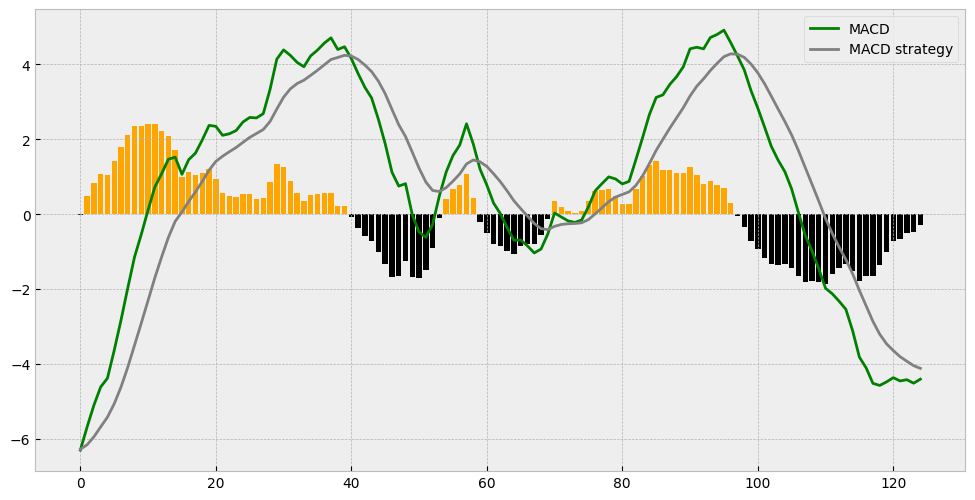

In [20]:
style.use('bmh')
fig, ax = plt.subplots(figsize = (12,6))

colors = np.where(data["macd_h"] > 0, "orange", 'black')

plt.bar(x = data.index, height = data.macd_h, color = colors)
plt.plot(data.index, data.macd, color = "green", label = 'MACD')
plt.plot(data.index, data.macd_s, color = "grey", label = "MACD strategy")
plt.legend()